In [2]:
%reload_ext autoreload
%autoreload 2

In [15]:
#export

from export.nb_01 import *

In [17]:
data_path=Path(r'd:\datasets\data')
path=data_path/'cifar10'

train_ds=ImageDataset.from_folder(path/'train')
valid_ds=ImageDataset.from_folder(path/'test', train_ds.classes)

x=train_ds[1][0]
bs=128
c=len(train_ds.classes)
len(train_ds)

50000

In [20]:
tfms=[flip_lr(p=0.5),
     pad(padding=4),
     crop(size=32, row_pct=(0,1), col_pct=(0,1.))]

In [24]:
train_tds=DatasetTfm(train_ds, tfms)

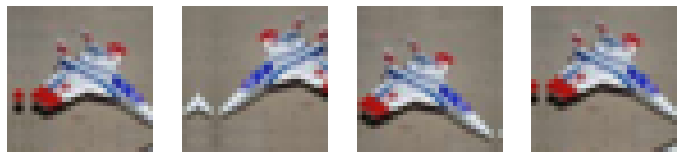

In [25]:
_, axes=plt.subplots(1,4, figsize=(12, 9))
for ax in axes.flat: train_tds[1][0].show(ax)

In [26]:
#export
def normalize(x:TensorImage, mean:float,std:float)->TensorImage:   return (x-mean[...,None,None]) / std[...,None,None]
def denormalize(x:TensorImage, mean:float,std:float)->TensorImage: return x*std[...,None,None] + mean[...,None,None]

def normalize_batch(b:Tuple[Tensor,Tensor], mean:float, std:float, do_y:bool=False)->Tuple[Tensor,Tensor]:
    "`b` = `x`,`y` - normalize `x` array of imgs and `do_y` optionally `y`"
    x,y = b
    x = normalize(x,mean,std)
    if do_y: y = normalize(y,mean,std)
    return x,y

def normalize_funcs(mean:float, std, do_y=False, device=None)->[Callable,Callable]:
    "Create normalize/denormalize func using `mean` and `std`, can specify `do_y` and `device`"
    if device is None: device=default_device
    return (partial(normalize_batch, mean=mean.to(device),std=std.to(device)),
            partial(denormalize,     mean=mean,           std=std))

def transform_datasets(train_ds:Dataset, valid_ds:Dataset, test_ds:Optional[Dataset]=None, 
                       tfms:Optional[Tuple[TfmList,TfmList]]=None, **kwargs:Any):
    "Create train, valid and maybe test DatasetTfm` using `tfms` = (train_tfms,valid_tfms)"
    res = [DatasetTfm(train_ds, tfms[0],  **kwargs),
           DatasetTfm(valid_ds, tfms[1],  **kwargs)]
    if test_ds is not None: res.append(DatasetTfm(test_ds, tfms[1],  **kwargs))
    return res

In [27]:
#export
# CIFAR 10 stats looked up on google 
cifar_stats = (tensor([0.491, 0.482, 0.447]), tensor([0.247, 0.243, 0.261]))
cifar_norm,cifar_denorm = normalize_funcs(*cifar_stats)

def num_cpus()->int:
    "Get number of cpus"
    try:                   return len(os.sched_getaffinity(0))
    except AttributeError: return os.cpu_count()
    
default_cpus = min(16, num_cpus())

In [28]:
#export
@dataclass
class DeviceDataLoader():
    "Binds a `DataLoader` to a `torch.device`"
    dl: DataLoader
    device: torch.device
    tfms: List[Callable]=None
    collate_fn: Callable=data_collate
    def __post_init__(self):
        self.dl.collate_fn=self.collate_fn
        self.tfms = listify(self.tfms)

    def __len__(self)->int: return len(self.dl)
    def __getattr__(self,k:str)->Any: return getattr(self.dl, k)
    
    def add_tfm(self,tfm:Callable)->None:    self.tfms.append(tfm)
    def remove_tfm(self,tfm:Callable)->None: self.tfms.remove(tfm)

    def proc_batch(self,b:Tensor)->Tensor:
        "Proces batch `b` of `TensorImage`"
        b = to_device(b, self.device)
        for f in listify(self.tfms): b = f(b)
        return b

    def __iter__(self):
        "Process and returns items from `DataLoader`"
        self.gen = map(self.proc_batch, self.dl)
        return iter(self.gen)

    @classmethod
    def create(cls, dataset:Dataset, bs:int=1, shuffle:bool=False, device:torch.device=default_device, 
               tfms:TfmList=tfms, num_workers:int=default_cpus, collate_fn:Callable=data_collate, **kwargs:Any):
        "Create DeviceDataLoader from `dataset` with `batch_size` and `shuffle`: processs using `num_workers`"
        return cls(DataLoader(dataset, batch_size=bs, shuffle=shuffle, num_workers=num_workers, **kwargs),
                   device=device, tfms=tfms, collate_fn=collate_fn)

In [29]:
#export
class DataBunch():
    "Bind `train_dl`,`valid_dl` and`test_dl` to `device`. tfms are DL tfms (normalize). `path` is for models."
    def __init__(self, train_dl:DataLoader, valid_dl:DataLoader, test_dl:Optional[DataLoader]=None,
                 device:torch.device=None, tfms:Optional[Collection[Callable]]=None, path:PathOrStr='.'):
        "Bind `train_dl`,`valid_dl` and`test_dl` to `device`. tfms are DL tfms (normalize). `path` is for models."
        self.device = default_device if device is None else device
        self.train_dl = DeviceDataLoader(train_dl, self.device, tfms=tfms)
        self.valid_dl = DeviceDataLoader(valid_dl, self.device, tfms=tfms)
        self.test_dl  = DeviceDataLoader(test_dl,  self.device, tfms=tfms) if test_dl else None
        self.path = Path(path)

    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None,
               path='.', bs=64, ds_tfms=None, num_workers=default_cpus,
               tfms=None, device=None, size=None, **kwargs)->'DataBunch':
        "`DataBunch` factory. `bs` batch size, `ds_tfms` for `Dataset`, `tfms` for `DataLoader`"
        datasets = [train_ds,valid_ds]
        if test_ds is not None: datasets.append(test_ds)
        if ds_tfms: datasets = transform_datasets(*datasets, tfms=ds_tfms, size=size, **kwargs)
        dls = [DataLoader(*o, num_workers=num_workers) for o in
               zip(datasets, (bs,bs*2,bs*2), (True,False,False))]
        return cls(*dls, path=path, device=device, tfms=tfms)
    
    def __getattr__(self,k)->Any: return getattr(self.train_ds, k)
    def holdout(self, is_test:bool=False)->DeviceDataLoader: 
        "Returns correct holdout `Dataset` for test vs validation (`is_test`)"
        return self.test_dl if is_test else self.valid_dl

    @property
    def train_ds(self)->Dataset: return self.train_dl.dl.dataset
    @property
    def valid_ds(self)->Dataset: return self.valid_dl.dl.dataset

def data_from_imagefolder(path:PathOrStr, train:PathOrStr='train', valid:PathOrStr='valid', 
                          test:Optional[PathOrStr]=None, **kwargs:Any):
    "Create `DataBunch` from imagenet style dataset in `path` with `train`,`valid`,`test` subfolders"
    path=Path(path)
    train_ds = ImageDataset.from_folder(path/train)
    datasets = [train_ds, ImageDataset.from_folder(path/valid, classes=train_ds.classes)]
    if test: datasets.append(ImageDataset.from_single_folder(
        path/test,classes=train_ds.classes))
    return DataBunch.create(*datasets, path=path, **kwargs)

In [35]:
data = data_from_imagefolder(path, valid='test', bs=bs, train_tfm=tfms, tfms=cifar_norm)
data.device

device(type='cuda')

In [ ]:
x,y = next(iter(data.train_dl))
x = x.cpu()
x = cifar_denorm(x)
show_images(x,y,6,train_ds.classes, figsize=(9,10))
print(x.min(),x.max(),x.mean(),x.std())

In [ ]:
learn = Learner(data, simple_cnn([3,16,16,c], [3,3,3], [2,2,2]))
opt_fn = partial(optim.SGD, momentum=0.9)

In [ ]:
learn.fit(1, 0.1, opt_fn=opt_fn)